# Projet_8 : cityscapes dataset

This notebook will contain all exploration regarding the EDA of cityscape dataset, the choice of a model to segment images, and the pipeline to do it

The CityScape dataset contains pre-treated images, so we won't be able to work with the origin images 
We will probably have to augment data 


In [7]:
#librairies
# classic Librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import shutil
from collections import Counter
from collections import namedtuple

from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf
import keras
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
from segmentation_models import get_preprocessing
import torch
from torch import nn

# image imports
from matplotlib.image import imread
import PIL
from PIL import Image, ImageFilter, ImageEnhance

from tensorflow.keras import layers, models
import tensorflow.keras.backend as K
from keras.metrics import IoU
from tensorflow.keras.metrics import MeanIoU

import albumentations as A
import cv2

Segmentation Models: using `tf.keras` framework.


C:\Users\kanam\anaconda3\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [404]:
"""from collections import namedtuple


#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )
"""

"from collections import namedtuple\n\n\n#--------------------------------------------------------------------------------\n# Definitions\n#--------------------------------------------------------------------------------\n\n# a label and all meta information\nLabel = namedtuple( 'Label' , [\n\n    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .\n                    # We use them to uniquely name a class\n\n    'id'          , # An integer ID that is associated with this label.\n                    # The IDs are used to represent the label in ground truth images\n                    # An ID of -1 means that this label does not have an ID and thus\n                    # is ignored when creating ground truth images (e.g. license plate).\n                    # Do not modify these IDs, since exactly these IDs are expected by the\n                    # evaluation server.\n\n    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then creat

In [405]:
"""
#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]
"""

"\n#--------------------------------------------------------------------------------\n# A list of all labels\n#--------------------------------------------------------------------------------\n\n# Please adapt the train IDs as appropriate for your approach.\n# Note that you might want to ignore labels with ID 255 during training.\n# Further note that the current train IDs are only a suggestion. You can use whatever you like.\n# Make sure to provide your results using the original IDs and not the training IDs.\n# Note that many IDs are ignored in evaluation and thus you never need to predict these!\n\nlabels = [\n    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color\n    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),\n    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),

In [406]:
"""for label in labels:
    print(label.id, "is", label.name,"and is in category", label.categoryId)"""

'for label in labels:\n    print(label.id, "is", label.name,"and is in category", label.categoryId)'

In [407]:
"""#display classes distribution

MAIN_PATH = os.path.join(mask_path, city)

class_counts = Counter()

for mask_file in mask_files:
    FILE_PATH = os.path.join(MAIN_PATH, os.path.basename(mask_file))
    #print(FILE_PATH)
    if FILE_PATH.endswith("_labelIds.png"):
        mask = cv2.imread(FILE_PATH, cv2.IMREAD_GRAYSCALE)
        class_counts.update(mask.flatten())
        
        plt.bar(class_counts.keys(), class_counts.values())
        plt.xlabel("Classes CityScapes (label IDs)")
        plt.ylabel("Nombre de pixels")
        plt.title("Distribution des classes dans CityScapes")
        plt.show()"""

'#display classes distribution\n\nMAIN_PATH = os.path.join(mask_path, city)\n\nclass_counts = Counter()\n\nfor mask_file in mask_files:\n    FILE_PATH = os.path.join(MAIN_PATH, os.path.basename(mask_file))\n    #print(FILE_PATH)\n    if FILE_PATH.endswith("_labelIds.png"):\n        mask = cv2.imread(FILE_PATH, cv2.IMREAD_GRAYSCALE)\n        class_counts.update(mask.flatten())\n        \n        plt.bar(class_counts.keys(), class_counts.values())\n        plt.xlabel("Classes CityScapes (label IDs)")\n        plt.ylabel("Nombre de pixels")\n        plt.title("Distribution des classes dans CityScapes")\n        plt.show()'

In [408]:
"""#we'll copy a few files from each cities from the train directory

#file_to_copy = x.endswith("_labelIds.png")
main_path = "data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train"
list_of_cities = os.listdir(main_path)
for city in list_of_cities:
    files = sorted(os.listdir(os.path.join(main_path, city)))
    # print(len(files)) # how populated is the folder 
    label_files = []
    for file in files:
        if file.endswith("_labelIds.png"):
            # print(file)
            label_files.append(file)

#label_files
"""

'#we\'ll copy a few files from each cities from the train directory\n\n#file_to_copy = x.endswith("_labelIds.png")\nmain_path = "data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train"\nlist_of_cities = os.listdir(main_path)\nfor city in list_of_cities:\n    files = sorted(os.listdir(os.path.join(main_path, city)))\n    # print(len(files)) # how populated is the folder \n    label_files = []\n    for file in files:\n        if file.endswith("_labelIds.png"):\n            # print(file)\n            label_files.append(file)\n\n#label_files\n'

In [409]:
"""# take 10% of each folder 
total = len(label_files)
percent = np.round((total)/10).astype(np.int64)
int_percent = percent
x = np.random.randint(0, total+1, percent)
x

for each in x:
    print(label_files[each-1])
    #label_files[x]
    #print(os.path.join(main_path, city))"""

'# take 10% of each folder \ntotal = len(label_files)\npercent = np.round((total)/10).astype(np.int64)\nint_percent = percent\nx = np.random.randint(0, total+1, percent)\nx\n\nfor each in x:\n    print(label_files[each-1])\n    #label_files[x]\n    #print(os.path.join(main_path, city))'

In [410]:
"""path_to_train_file = "data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train"
train_copies_folder = "data/train_copies/"

list_of_cities = os.listdir(path_to_train_file)

files_to_copy = []

#select 10% of _labelIds files randomly for each cities
for city in list_of_cities:
    files = sorted(os.listdir(os.path.join(path_to_train_file, city)))
    label_files = []
    
    for file in files:
        if file.endswith("_labelIds.png"):
            label_files.append(file)
    total = len(label_files)
    percent = np.round((total)/10).astype(np.int64)
    random_selection = np.random.choice(total, percent, replace=False)
                
    for each in random_selection:
        path = os.path.join(city,label_files[each])
        files_to_copy.append(path)

#copy everything (v2)
if not os.path.exists(train_copies_folder):
    os.makedirs(train_copies_folder)
    for mask_file in files_to_copy:
        FILE_PATH = os.path.join(path_to_train_file, mask_file)
        FILE = os.path.basename(mask_file)
        COPIES_PATH = os.path.join(train_copies_folder, FILE)
        shutil.copy(FILE_PATH, COPIES_PATH)
        #print("Successfully copied :", mask_file)
    print("Successfully copied :", len(files_to_copy), "files")
else:
    print("folder already exists, nothing will be copied")"""

'path_to_train_file = "data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train"\ntrain_copies_folder = "data/train_copies/"\n\nlist_of_cities = os.listdir(path_to_train_file)\n\nfiles_to_copy = []\n\n#select 10% of _labelIds files randomly for each cities\nfor city in list_of_cities:\n    files = sorted(os.listdir(os.path.join(path_to_train_file, city)))\n    label_files = []\n    \n    for file in files:\n        if file.endswith("_labelIds.png"):\n            label_files.append(file)\n    total = len(label_files)\n    percent = np.round((total)/10).astype(np.int64)\n    random_selection = np.random.choice(total, percent, replace=False)\n                \n    for each in random_selection:\n        path = os.path.join(city,label_files[each])\n        files_to_copy.append(path)\n\n#copy everything (v2)\nif not os.path.exists(train_copies_folder):\n    os.makedirs(train_copies_folder)\n    for mask_file in files_to_copy:\n        FILE_PATH = os.path.join(path_to_train_file, mask_file)\n     

In [411]:
"""mask_folder = "data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train"
img_folder = "data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train"
copies_folder = "data/copies_all"

list_of_cities = os.listdir(mask_folder)

selected_files = []

#select 10% of _labelIds files randomly for each cities
for city in list_of_cities:
    mask_files = sorted(os.listdir(os.path.join(mask_folder, city)))
    img_files = sorted(os.listdir(os.path.join(img_folder, city)))
    label_files = []

    for file in mask_files:
        if file.endswith("_labelIds.png"):
            label_files.append(file)
            
    total = len(label_files)
    percent = np.round((total)/10).astype(np.int64)
    random_selection = np.random.choice(total, percent, replace=False)
                
    for each in random_selection:
        img_path = os.path.join(city, img_files[each])
        label_path = os.path.join(city, label_files[each])
        selected_files.extend([label_path, img_path])

#selected_files

#display first images and their label
for file in selected_files[:2]:
        if file.endswith("_labelIds.png"):    
            file_path = os.path.join(mask_folder, file)
            # with PILLOW
        else:
            file_path = os.path.join(img_folder, file)
        img = Image.open(file_path) 
        
        #img.show() => open image navigator by default
        plt.imshow(img)
        plt.show()

"""

'mask_folder = "data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train"\nimg_folder = "data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train"\ncopies_folder = "data/copies_all"\n\nlist_of_cities = os.listdir(mask_folder)\n\nselected_files = []\n\n#select 10% of _labelIds files randomly for each cities\nfor city in list_of_cities:\n    mask_files = sorted(os.listdir(os.path.join(mask_folder, city)))\n    img_files = sorted(os.listdir(os.path.join(img_folder, city)))\n    label_files = []\n\n    for file in mask_files:\n        if file.endswith("_labelIds.png"):\n            label_files.append(file)\n            \n    total = len(label_files)\n    percent = np.round((total)/10).astype(np.int64)\n    random_selection = np.random.choice(total, percent, replace=False)\n                \n    for each in random_selection:\n        img_path = os.path.join(city, img_files[each])\n        label_path = os.path.join(city, label_files[each])\n        selected_files.extend([label_path, img_path

In [412]:
"""#copy files (v3)
if os.path.exists(copies_folder):
    print("path already exists, nothing was copied")
else:
    os.makedirs(copies_folder)
    for file in selected_files:
        FILE = os.path.basename(file)
        if file.endswith("_labelIds.png"):
            MASK_FILE_PATH = os.path.join(mask_folder, file)
            COPIES_PATH = os.path.join(copies_folder, FILE)
            #img = Image.open(MASK_FILE_PATH)
            shutil.copy(MASK_FILE_PATH, COPIES_PATH)
        else:
            IMG_FILE_PATH = os.path.join(img_folder, file)
            COPIES_PATH = os.path.join(copies_folder, FILE)
            #img = Image.open(IMG_FILE_PATH)
            shutil.copy(IMG_FILE_PATH, COPIES_PATH)
        #img.show() => open image navigator by default
        #plt.imshow(img)
        #print(COPIES_PATH)
        #plt.show()
    print("Successfully copied :", len(selected_files), "files")
"""

'#copy files (v3)\nif os.path.exists(copies_folder):\n    print("path already exists, nothing was copied")\nelse:\n    os.makedirs(copies_folder)\n    for file in selected_files:\n        FILE = os.path.basename(file)\n        if file.endswith("_labelIds.png"):\n            MASK_FILE_PATH = os.path.join(mask_folder, file)\n            COPIES_PATH = os.path.join(copies_folder, FILE)\n            #img = Image.open(MASK_FILE_PATH)\n            shutil.copy(MASK_FILE_PATH, COPIES_PATH)\n        else:\n            IMG_FILE_PATH = os.path.join(img_folder, file)\n            COPIES_PATH = os.path.join(copies_folder, FILE)\n            #img = Image.open(IMG_FILE_PATH)\n            shutil.copy(IMG_FILE_PATH, COPIES_PATH)\n        #img.show() => open image navigator by default\n        #plt.imshow(img)\n        #print(COPIES_PATH)\n        #plt.show()\n    print("Successfully copied :", len(selected_files), "files")\n'

In [413]:
"""#et maintenant on copie image et labels ! je ne copie que les labelIds ??? je transforme les image en labelsIds ????
copies_folder = "data/copies_all"

#copy everything (v2)
if not os.path.exists(copies_folder):
    os.makedirs(copies_folder)
    for file in selected_files:
        FILE = os.path.basename(file)
        if file.endswith("_labelIds.png"):
            MASK_FILE_PATH = os.path.join(mask_folder, file)
            COPIES_PATH = os.path.join(copies_folder, FILE)
        else:
            IMG_FILE_PATH = os.path.join(img_folder, file)
            COPIES_PATH = os.path.join(copies_folder, FILE)
        #shutil.copy(IMG_FILE_PATH, COPIES_PATH)
        #shutil.copy(MASK_FILE_PATH, COPIES_PATH)
        #print("Successfully copied :", mask_file)
    print("Successfully copied :", len(selected_files), "files")
else:
    print("folder already exists, nothing will be copied")"""

'#et maintenant on copie image et labels ! je ne copie que les labelIds ??? je transforme les image en labelsIds ????\ncopies_folder = "data/copies_all"\n\n#copy everything (v2)\nif not os.path.exists(copies_folder):\n    os.makedirs(copies_folder)\n    for file in selected_files:\n        FILE = os.path.basename(file)\n        if file.endswith("_labelIds.png"):\n            MASK_FILE_PATH = os.path.join(mask_folder, file)\n            COPIES_PATH = os.path.join(copies_folder, FILE)\n        else:\n            IMG_FILE_PATH = os.path.join(img_folder, file)\n            COPIES_PATH = os.path.join(copies_folder, FILE)\n        #shutil.copy(IMG_FILE_PATH, COPIES_PATH)\n        #shutil.copy(MASK_FILE_PATH, COPIES_PATH)\n        #print("Successfully copied :", mask_file)\n    print("Successfully copied :", len(selected_files), "files")\nelse:\n    print("folder already exists, nothing will be copied")'

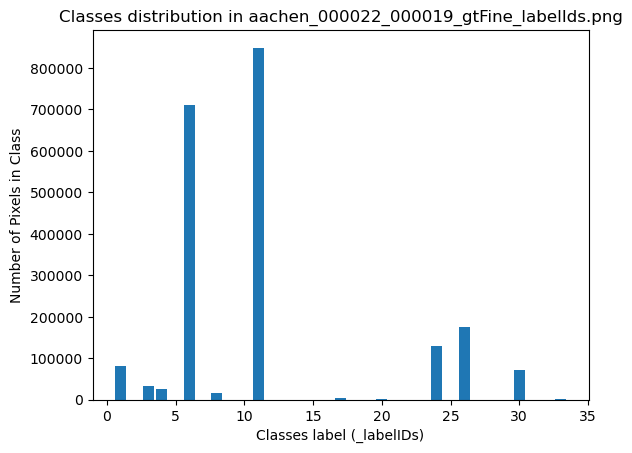

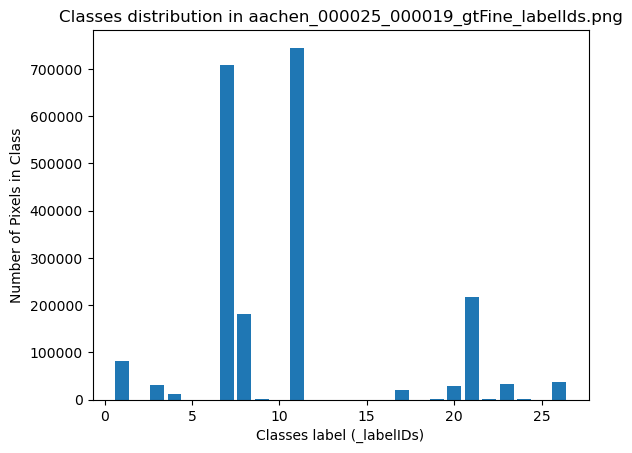

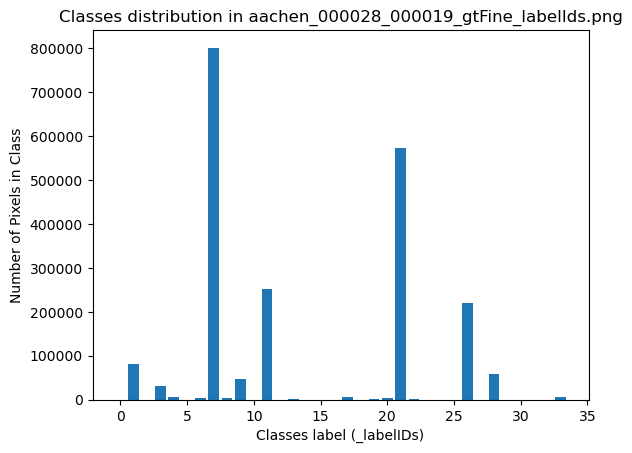

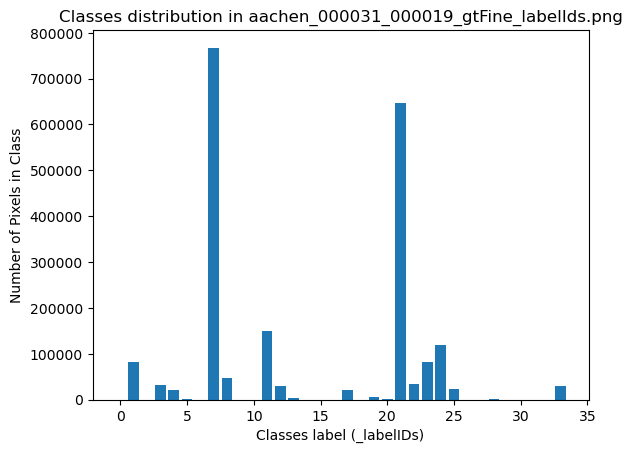

In [414]:
#display class distribution of a few files to ensure results
copies_folder = "data/train/masks"

copied_files = sorted(os.listdir(copies_folder))[:4]

#classes counter
for file in copied_files:
    if file.endswith("_labelIds.png"):
        FILE_PATH = os.path.join(copies_folder, file)
        #print(FILE_PATH)
    
        class_counts = Counter()
    
        mask = cv2.imread(FILE_PATH, cv2.IMREAD_GRAYSCALE)
        class_counts.update(mask.flatten())
        
        plt.bar(class_counts.keys(), class_counts.values())
        plt.xlabel("Classes label (_labelIDs)")
        plt.ylabel("Number of Pixels in Class")
        plt.title(f"Classes distribution in {file}")
        plt.show()
    else:
        print("Raw image, won't display")
    


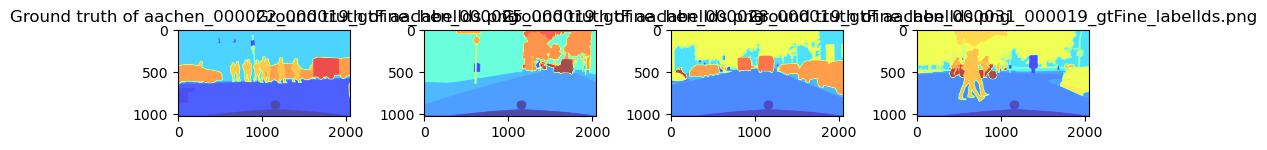

In [415]:
#display raw image and ground truth
fig, axes = plt.subplots(1, len(copied_files), figsize=(10, 20))

for i, file in enumerate(copied_files):
    FILE_PATH = os.path.join(copies_folder, os.path.basename(file))
    if file.endswith("_labelIds.png"):
        mask = cv2.imread(FILE_PATH, cv2.IMREAD_GRAYSCALE)
        axes[i].imshow(mask, cmap="jet", alpha=0.7)
        axes[i].set_title(f"Ground truth of {file}")
    else:
        img = Image.open(FILE_PATH)
        axes[i].imshow(img)
        axes[i].set_title(file)
        
    
    #axes[i].axis("off")

plt.tight_layout()
plt.show() 

In [416]:
"""#Display mask
fig, axes = plt.subplots(len(copied_mask_files), 1, figsize=(10, 20))

for i, mask_file in enumerate(copied_mask_files):
    FILE_PATH = os.path.join(copies_folder, os.path.basename(mask_file))
    mask = cv2.imread(FILE_PATH, cv2.IMREAD_GRAYSCALE)
    axes[i].imshow(mask, cmap="jet", alpha=0.7)
    axes[i].set_title(mask_file)
    axes[i].axis("off")

plt.tight_layout()
plt.show()"""

'#Display mask\nfig, axes = plt.subplots(len(copied_mask_files), 1, figsize=(10, 20))\n\nfor i, mask_file in enumerate(copied_mask_files):\n    FILE_PATH = os.path.join(copies_folder, os.path.basename(mask_file))\n    mask = cv2.imread(FILE_PATH, cv2.IMREAD_GRAYSCALE)\n    axes[i].imshow(mask, cmap="jet", alpha=0.7)\n    axes[i].set_title(mask_file)\n    axes[i].axis("off")\n\nplt.tight_layout()\nplt.show()'

In [417]:
"""#Generalize to 8 classes

#select only files to be converted
eligible_files = []
for file in os.listdir(copies_folder):
    if file.endswith("_labelIds.png"):
        eligible_files.append(file)
eligible_files

#create dictionnary
id_to_catId = {label.id: label.categoryId for label in labels}

#create generalized folder
output_path = "data/copies_generalized_classes"
if not os.path.exists(output_path):
    os.makedirs(output_path)

#checker if generalization is done
file_test = eligible_files[-1]
file_test_path = os.path.join(copies_folder, os.path.basename(file_test))
mask = cv2.imread(file_test_path, cv2.IMREAD_GRAYSCALE)
class_counts = Counter()
class_counts.update(mask.flatten())

if len(class_counts) == 8:
    print("generalization is already done")

else:
    print("need to generalize classes")
    
    transformer = np.vectorize(id_to_catId.get)
    
    for mask_file in eligible_files:
        mask_path = os.path.join(copies_folder, mask_file)
    
        # load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
        # apply new mask
        mask_transformed = transformer(mask)
    
        # save mask
        output_mask_path = os.path.join(output_path, mask_file)
        cv2.imwrite(output_mask_path, mask_transformed)

    print("generalization done")

#took 120 secs"""

'#Generalize to 8 classes\n\n#select only files to be converted\neligible_files = []\nfor file in os.listdir(copies_folder):\n    if file.endswith("_labelIds.png"):\n        eligible_files.append(file)\neligible_files\n\n#create dictionnary\nid_to_catId = {label.id: label.categoryId for label in labels}\n\n#create generalized folder\noutput_path = "data/copies_generalized_classes"\nif not os.path.exists(output_path):\n    os.makedirs(output_path)\n\n#checker if generalization is done\nfile_test = eligible_files[-1]\nfile_test_path = os.path.join(copies_folder, os.path.basename(file_test))\nmask = cv2.imread(file_test_path, cv2.IMREAD_GRAYSCALE)\nclass_counts = Counter()\nclass_counts.update(mask.flatten())\n\nif len(class_counts) == 8:\n    print("generalization is already done")\n\nelse:\n    print("need to generalize classes")\n    \n    transformer = np.vectorize(id_to_catId.get)\n    \n    for mask_file in eligible_files:\n        mask_path = os.path.join(copies_folder, mask_file)\

In [418]:
"""result = []
for file in os.listdir(copies_folder):
    if file.endswith("_leftImg8bit.png"):
        result.append(file)

len(result)"""

'result = []\nfor file in os.listdir(copies_folder):\n    if file.endswith("_leftImg8bit.png"):\n        result.append(file)\n\nlen(result)'

In [419]:
"""#create folder to save images related to masks
img_path = "data/copies_img_only"
if not os.path.exists(img_path):
    os.makedirs(img_path)
else:
    print("directory already exists")

for file in os.listdir(copies_folder):
    if file.endswith("_leftImg8bit.png"):
        copy_path = os.path.join(img_path, os.path.basename(file))
        origin_path = os.path.join(copies_folder, os.path.basename(file))
        #print(origin_path, "COPIED TO",copy_path)
        shutil.copy(origin_path, copy_path)

print("copied", len(os.listdir(img_path)) , "files")"""

'#create folder to save images related to masks\nimg_path = "data/copies_img_only"\nif not os.path.exists(img_path):\n    os.makedirs(img_path)\nelse:\n    print("directory already exists")\n\nfor file in os.listdir(copies_folder):\n    if file.endswith("_leftImg8bit.png"):\n        copy_path = os.path.join(img_path, os.path.basename(file))\n        origin_path = os.path.join(copies_folder, os.path.basename(file))\n        #print(origin_path, "COPIED TO",copy_path)\n        shutil.copy(origin_path, copy_path)\n\nprint("copied", len(os.listdir(img_path)) , "files")'

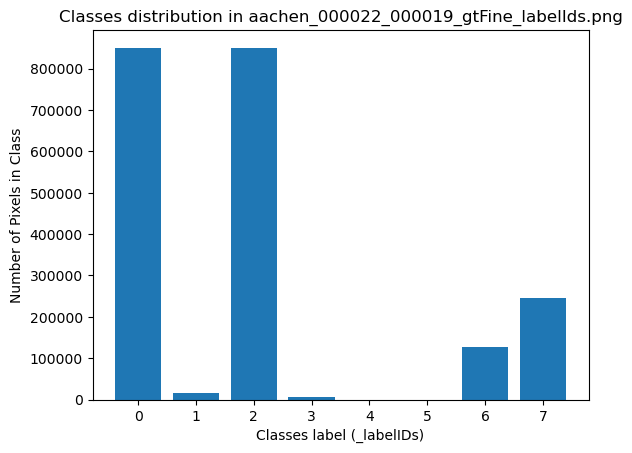

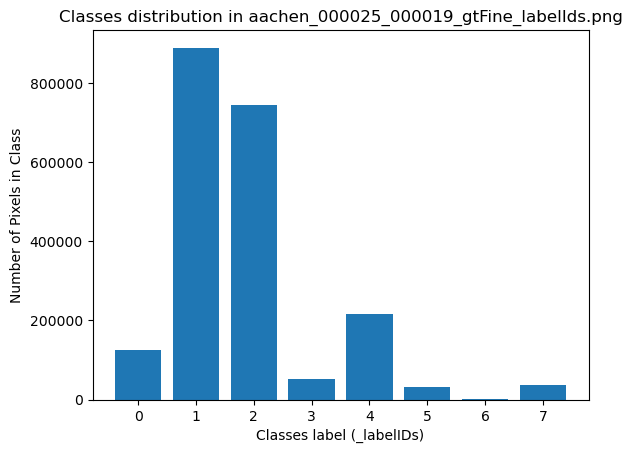

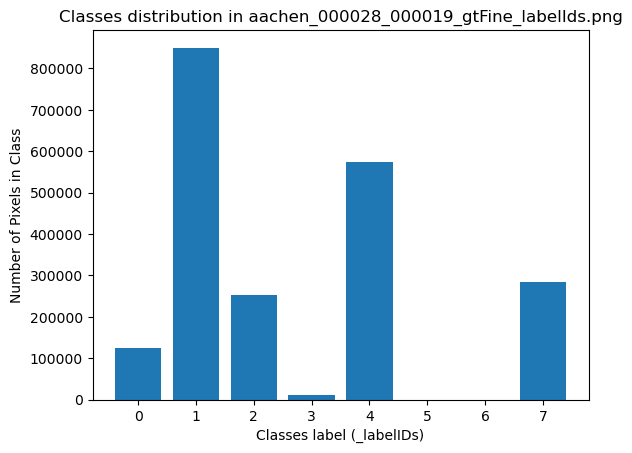

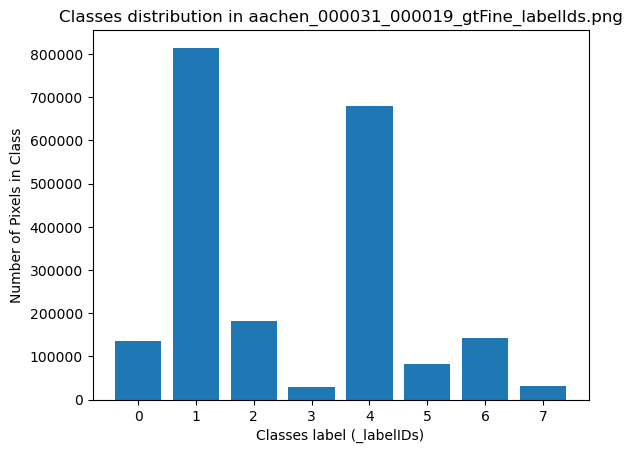

In [420]:
#checking the 4 first elements
output_path = "data/train/gen_masks"
generalized_mask_files = os.listdir(output_path)[:4]

#Generalized classes counter
for mask_file in generalized_mask_files:
    FILE_PATH = os.path.join(output_path, os.path.basename(mask_file))
    #print(FILE_PATH)

    class_counts = Counter()

    mask = cv2.imread(FILE_PATH, cv2.IMREAD_GRAYSCALE)
    class_counts.update(mask.flatten())
    
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel("Classes label (_labelIDs)")
    plt.ylabel("Number of Pixels in Class")
    plt.title(f"Classes distribution in {mask_file}")
    plt.show()

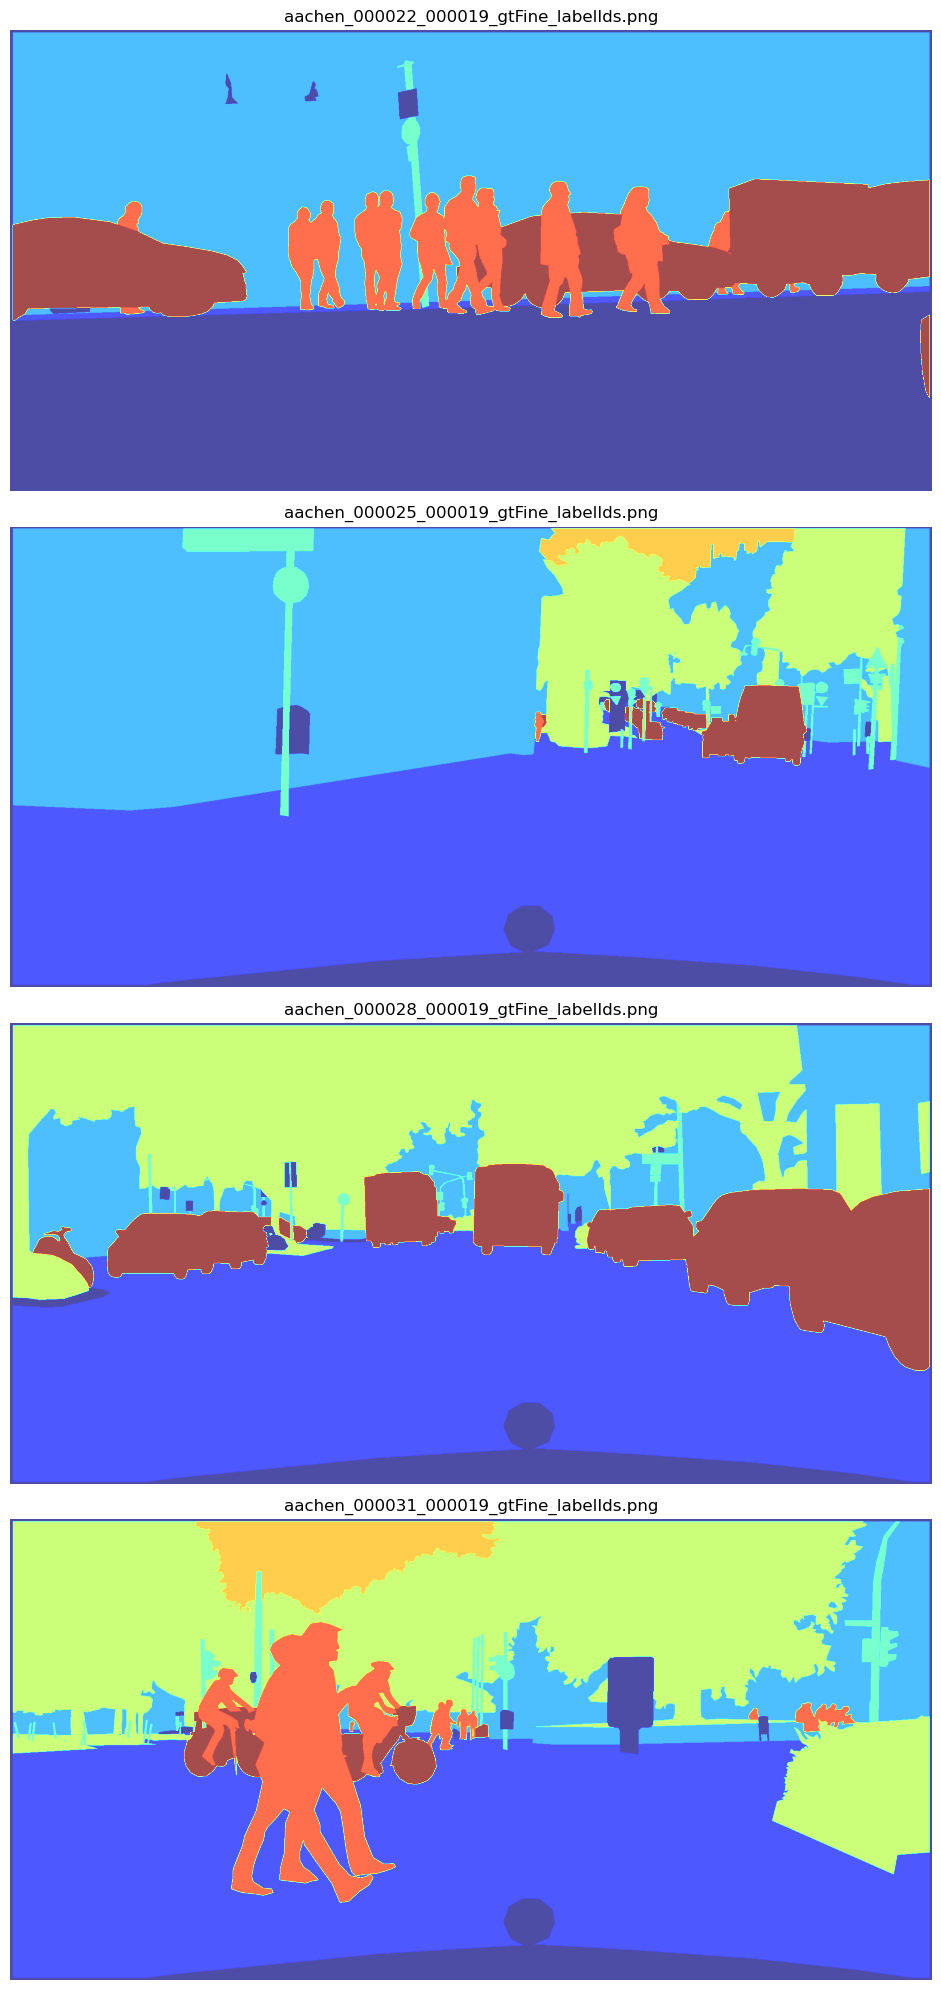

In [421]:
#Display mask
fig, axes = plt.subplots(len(generalized_mask_files), 1, figsize=(10, 20))

for i, mask_file in enumerate(generalized_mask_files):
    FILE_PATH = os.path.join(output_path, os.path.basename(mask_file))
    mask = cv2.imread(FILE_PATH, cv2.IMREAD_GRAYSCALE)
    axes[i].imshow(mask, cmap="jet", alpha=0.7)
    axes[i].set_title(mask_file)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

## EDA

Now that we have generalized our data into 8 classes, we can start investigating

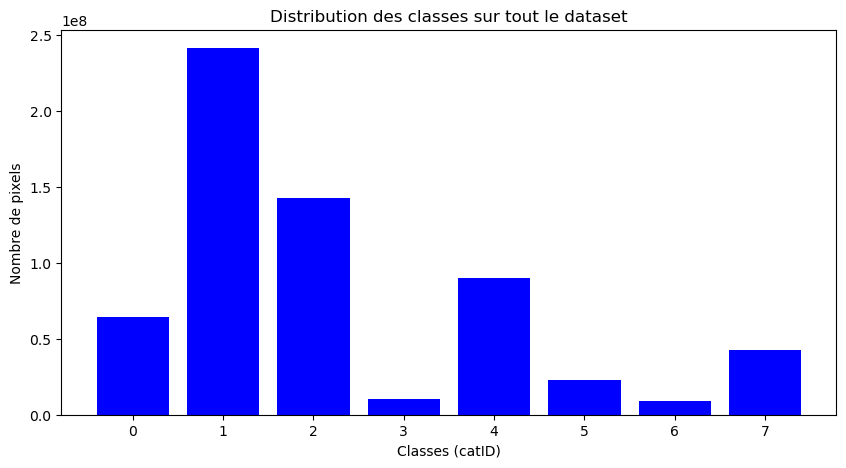

In [423]:
#What class distribution along the dataset pixel-wise ?

# Définition du chemin des masques transformés
generalized_mask_folder = "data/train/gen_masks"

# Initialiser un compteur pour toutes les classes
class_counts = Counter()

# Parcourir toutes les images du dataset
for mask_file in os.listdir(generalized_mask_folder):
    mask_path = os.path.join(generalized_mask_folder, mask_file)

    # Charger le masque en niveaux de gris
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Mettre à jour les comptes des classes
    class_counts.update(mask.flatten())

# Trier les classes par ID pour l'affichage
sorted_class_counts = dict(sorted(class_counts.items()))

# Afficher la distribution sous forme de graphe
plt.figure(figsize=(10, 5))
plt.bar(sorted_class_counts.keys(), sorted_class_counts.values(), color="blue")
plt.xlabel("Classes (catID)")
plt.ylabel("Nombre de pixels")
plt.title("Distribution des classes sur tout le dataset")
plt.xticks(list(sorted_class_counts.keys()))  # Afficher les labels correctement
plt.show()


Classes 3 and 6, "objects" and "human", seems to be the less represented classes. 

This means our problem is an imbalanced one.

We asserted that the classes are rare in pixels. We will now check if they are contained in each images, even if scarcely

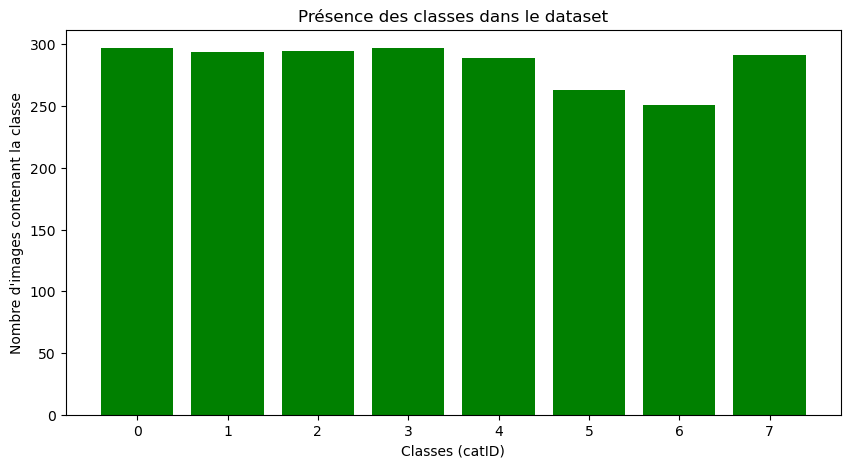

In [425]:
#are there any 'rare classes' in images ? 

# Initialiser un compteur du nombre d'images où chaque classe apparaît
class_presence = Counter()

# Parcourir toutes les images
for mask_file in os.listdir(generalized_mask_folder):
    mask_path = os.path.join(generalized_mask_folder, mask_file)

    # Charger le masque
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Vérifier quelles classes sont présentes dans cette image
    unique_classes = np.unique(mask)
    for cls in unique_classes:
        class_presence[cls] += 1  # Compte combien d'images contiennent cette classe

# Trier les classes par fréquence
sorted_class_presence = dict(sorted(class_presence.items()))

# Affichage
plt.figure(figsize=(10, 5))
plt.bar(sorted_class_presence.keys(), sorted_class_presence.values(), color="green")
plt.xlabel("Classes (catID)")
plt.ylabel("Nombre d'images contenant la classe")
plt.title("Présence des classes dans le dataset")
plt.xticks(list(sorted_class_presence.keys()))
plt.show()


Human seem to be the rarest class, which is not a good news, since the model could become blind to them.

The biggest issue here is that "human" pixels are the rarest class in image, and even then are scarce when present

We will have to DataAugment our training set to have them more present, probably centered towards them

will prepare the same split for validation and test sets

In [436]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

print("TensorFlow version:", tf.__version__)
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.17.0
GPUs disponibles: []


In [437]:
"""# Dice Loss pour la segmentation
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    iou_score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return iou_score

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.softmax(pred, dim=1)  # Softmax pour obtenir les probabilités
        target_one_hot = F.one_hot(target, num_classes=8).permute(0, 3, 1, 2).float()

        intersection = (pred * target_one_hot).sum(dim=(2,3))
        union = pred.sum(dim=(2,3)) + target_one_hot.sum(dim=(2,3))

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

# IoU Metric
def iou_score(pred, target):
    pred = torch.argmax(pred, dim=1)  # Convertir en classes
    intersection = (pred & target).float().sum((1, 2))
    union = (pred | target).float().sum((1, 2))
    return (intersection + 1e-6) / (union + 1e-6)  # Éviter la division par zéro

# Définition de la fonction de perte combinée
ciretrion = nn.CrossEntropyLoss()
dice_loss = DiceLoss()

# Fonction de perte combinée
def loss_fn(pred, target):
    return criterion(pred, target) + dice_loss(pred, target)
"""

'# Dice Loss pour la segmentation\ndef dice_coeff(y_true, y_pred):\n    smooth = 1.\n    y_true_f = K.flatten(y_true)\n    y_pred_f = K.flatten(y_pred)\n    intersection = K.sum(y_true_f * y_pred_f)\n    iou_score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)\n    return iou_score\n\nclass DiceLoss(nn.Module):\n    def __init__(self, smooth=1.):\n        super(DiceLoss, self).__init__()\n        self.smooth = smooth\n\n    def forward(self, pred, target):\n        pred = torch.softmax(pred, dim=1)  # Softmax pour obtenir les probabilités\n        target_one_hot = F.one_hot(target, num_classes=8).permute(0, 3, 1, 2).float()\n\n        intersection = (pred * target_one_hot).sum(dim=(2,3))\n        union = pred.sum(dim=(2,3)) + target_one_hot.sum(dim=(2,3))\n\n        dice = (2. * intersection + self.smooth) / (union + self.smooth)\n        return 1 - dice.mean()\n\n# IoU Metric\ndef iou_score(pred, target):\n    pred = torch.argmax(pred, dim=1)  # Converti

#### try 1

In [439]:
"""def unet_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Change the output layer for multi-class segmentation
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model"""

"def unet_model(input_shape, num_classes):\n    inputs = layers.Input(shape=input_shape)\n\n    # Encoder\n    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)\n    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)\n    p1 = layers.MaxPooling2D((2, 2))(c1)\n\n    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)\n    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)\n    p2 = layers.MaxPooling2D((2, 2))(c2)\n\n    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)\n    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)\n    p3 = layers.MaxPooling2D((2, 2))(c3)\n\n    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)\n    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)\n    p4 = layers.MaxPooling2D((2, 2))(c4)\n\n    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)\n    c5 = layers.Conv2D(1024, (

In [440]:
"""# Define input shape (height, width, channels)
input_shape = (256, 256, 3)  # Adjust based on your dataset
num_classes = 8  # Set this to the number of classes

# Create the U-Net model
model = unet_model(input_shape, num_classes)



# Compile the model with IoU as a metric
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=[dice_loss])

# Print the model summary
model.summary()"""

"# Define input shape (height, width, channels)\ninput_shape = (256, 256, 3)  # Adjust based on your dataset\nnum_classes = 8  # Set this to the number of classes\n\n# Create the U-Net model\nmodel = unet_model(input_shape, num_classes)\n\n\n\n# Compile the model with IoU as a metric\nmodel.compile(optimizer='adam', \n              loss='categorical_crossentropy', \n              metrics=[dice_loss])\n\n# Print the model summary\nmodel.summary()"

In [441]:
"""#careful diff between img and mask files

def load_data(image_dir, mask_dir, img_size=(256, 512), num_classes=8):
    all_images = os.listdir(image_dir)
    all_masks = os.listdir(mask_dir)
    images = []
    masks = []
    
    for img_name in all_images:
        img_path = os.path.join(image_dir, img_name)

        # Load and resize images
        image = cv2.imread(img_path)
        image = cv2.resize(image, img_size)
        images.append(image)
        
    for mask_name in all_masks:
        mask_path = os.path.join(mask_dir, mask_name)
        
        # Load and resize masks
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale
        mask = cv2.resize(mask, img_size)

        # One-hot encode the mask
        mask_one_hot = np.zeros((img_size[0], img_size[1], num_classes))
        for i in range(num_classes):
            mask_one_hot[:, :, i] = (mask == i).astype(int)
        masks.append(mask_one_hot)

    images = np.array(images) / 255.0  # Normalize images
    masks = np.array(masks)  # Masks are already in one-hot format
    
    return images, masks

# Example usage
#image_dir = 'data/copies_img_only'
#mask_dir = 'data/copies_generalized_classes'
#X, y = load_data(image_dir, mask_dir, num_classes=num_classes)"""


"#careful diff between img and mask files\n\ndef load_data(image_dir, mask_dir, img_size=(256, 512), num_classes=8):\n    all_images = os.listdir(image_dir)\n    all_masks = os.listdir(mask_dir)\n    images = []\n    masks = []\n    \n    for img_name in all_images:\n        img_path = os.path.join(image_dir, img_name)\n\n        # Load and resize images\n        image = cv2.imread(img_path)\n        image = cv2.resize(image, img_size)\n        images.append(image)\n        \n    for mask_name in all_masks:\n        mask_path = os.path.join(mask_dir, mask_name)\n        \n        # Load and resize masks\n        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale\n        mask = cv2.resize(mask, img_size)\n\n        # One-hot encode the mask\n        mask_one_hot = np.zeros((img_size[0], img_size[1], num_classes))\n        for i in range(num_classes):\n            mask_one_hot[:, :, i] = (mask == i).astype(int)\n        masks.append(mask_one_hot)\n\n    images 

In [442]:
"""#I don't need this, as dataset is already split, but will do it anyway for test

# Split the data into training and validation sets


#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train=X, y



# Train the model
history = model.fit(X_train, y_train, 
                    #validation_data=(X_val, y_val), 
                    epochs=10,  # Adjust the number of epochs as needed
                    batch_size=8)  # Adjust the batch size as needed

#1320 secs"""

"#I don't need this, as dataset is already split, but will do it anyway for test\n\n# Split the data into training and validation sets\n\n\n#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)\nX_train, y_train=X, y\n\n\n\n# Train the model\nhistory = model.fit(X_train, y_train, \n                    #validation_data=(X_val, y_val), \n                    epochs=10,  # Adjust the number of epochs as needed\n                    batch_size=8)  # Adjust the batch size as needed\n\n#1320 secs"

In [443]:
"""# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')"""

"# Evaluate the model\nval_loss, val_accuracy = model.evaluate(X_val, y_val)\nprint(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')"

In [444]:
"""X_val_path = "data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/lindau"
X_val_list = os.listdir("data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/lindau")
X_val_path = os.path.join(X_val_path, X_val_list[1])

X_val = Image.open(X_val_path)
#img = Image.open(X_val)
plt.imshow(X_val)

X_val.shape"""

'X_val_path = "data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/lindau"\nX_val_list = os.listdir("data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/lindau")\nX_val_path = os.path.join(X_val_path, X_val_list[1])\n\nX_val = Image.open(X_val_path)\n#img = Image.open(X_val)\nplt.imshow(X_val)\n\nX_val.shape'

In [445]:
"""#select a test file
X_val_path = "data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/lindau"
X_val_list = os.listdir("data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/lindau")
X_val_path = os.path.join(X_val_path, X_val_list[1])

# Make predictions
X_val_image = cv2.imread(X_val_path)
X_val_image = cv2.resize(X_val_image, (256, 256))
X_val_image = np.array(X_val_image) / 255.0 #normalize

predictions = model.predict(X_val_image)

# Convert predictions to class labels
predictions_classes = np.argmax(predictions, axis=-1)

# Visualize the results
def visualize_predictions(images, masks, predictions, num=2):
    plt.figure(figsize=(15, 10))
    for i in range(num):
        # Original Image
        plt.subplot(3, num, i + 1)
        plt.imshow(images[i])
        plt.title("Image")
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(3, num, i + 1 + num)
        plt.imshow(np.argmax(masks[i], axis=-1), cmap='jet')  # Show true mask
        plt.title("True Mask")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(3, num, i + 1 + 2 * num)
        plt.imshow(predictions[i], cmap='jet')  # Show predicted mask
        plt.title("Predicted Mask")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Visualize the first 5 predictions
visualize_predictions(X_val, y_val, predictions_classes)"""

'#select a test file\nX_val_path = "data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/lindau"\nX_val_list = os.listdir("data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/lindau")\nX_val_path = os.path.join(X_val_path, X_val_list[1])\n\n# Make predictions\nX_val_image = cv2.imread(X_val_path)\nX_val_image = cv2.resize(X_val_image, (256, 256))\nX_val_image = np.array(X_val_image) / 255.0 #normalize\n\npredictions = model.predict(X_val_image)\n\n# Convert predictions to class labels\npredictions_classes = np.argmax(predictions, axis=-1)\n\n# Visualize the results\ndef visualize_predictions(images, masks, predictions, num=2):\n    plt.figure(figsize=(15, 10))\n    for i in range(num):\n        # Original Image\n        plt.subplot(3, num, i + 1)\n        plt.imshow(images[i])\n        plt.title("Image")\n        plt.axis("off")\n\n        # Ground Truth Mask\n        plt.subplot(3, num, i + 1 + num)\n        plt.imshow(np.argmax(masks[i], axis=-1), cmap=\'jet\')  # Show

#### try 2

In [447]:
"""
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)  # Adjust channels as needed
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0, 1]
    return image

def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # Assuming masks are single-channel
    mask = tf.image.convert_image_dtype(mask, tf.float32)  # Normalize to [0, 1]
    return mask

def load_data(image_dir, mask_dir):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])
    
    # Create a TensorFlow Dataset for images
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Create a TensorFlow Dataset for masks
    mask_dataset = tf.data.Dataset.from_tensor_slices(mask_paths)
    mask_dataset = mask_dataset.map(load_mask, num_parallel_calls=tf.data.AUTOTUNE)

    # Combine images and masks into a single dataset
    dataset = tf.data.Dataset.zip((image_dataset, mask_dataset))
    
    return dataset

# Define your directories
image_dir = 'data/train/images'
mask_dir = 'data/train/gen_masks'

# Load the dataset
dataset = load_data(image_dir, mask_dir)

# Optionally, you can batch and shuffle the dataset
batch_size = 32
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Now you can use `dataset` for training your model"""

"\ndef load_image(image_path):\n    image = tf.io.read_file(image_path)\n    image = tf.image.decode_png(image, channels=3)  # Adjust channels as needed\n    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0, 1]\n    return image\n\ndef load_mask(mask_path):\n    mask = tf.io.read_file(mask_path)\n    mask = tf.image.decode_png(mask, channels=1)  # Assuming masks are single-channel\n    mask = tf.image.convert_image_dtype(mask, tf.float32)  # Normalize to [0, 1]\n    return mask\n\ndef load_data(image_dir, mask_dir):\n    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])\n    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])\n    \n    # Create a TensorFlow Dataset for images\n    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)\n    image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\n\n    # Create a TensorFlow Dataset for masks\n    mask

In [448]:
#dataset

In [449]:
"""for images, masks in dataset.take(1):  # Take one batch
    print(images.shape)  # Should print (batch_size, height, width, 3)
    print(masks.shape)   # Should print (batch_size, height, width, 1)"""

'for images, masks in dataset.take(1):  # Take one batch\n    print(images.shape)  # Should print (batch_size, height, width, 3)\n    print(masks.shape)   # Should print (batch_size, height, width, 1)'

In [450]:
"""#images must be resized to 512/512

def resize_image(image, img_size):
    image = cv2.resize(image, img_size)
    return image"""

'#images must be resized to 512/512\n\ndef resize_image(image, img_size):\n    image = cv2.resize(image, img_size)\n    return image'

In [451]:
"""train_images_path = "data/train/images"
train_images_list = os.listdir(train_images_path)
image = train_images_list[0]
image"""

'train_images_path = "data/train/images"\ntrain_images_list = os.listdir(train_images_path)\nimage = train_images_list[0]\nimage'

### Model exploration with Segmentation_Models

Segmentation_model will provide the UNet architecture and also allow us to test different backbones.

In [453]:
#using https://github.com/qubvel/segmentation_models

In [454]:
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

In [455]:
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss, cce_jaccard_loss
from segmentation_models.metrics import iou_score

In [11]:
#loader function
def load_data(image_dir, mask_dir, img_size=(512, 512), num_classes=8):
    all_images = os.listdir(image_dir)
    all_masks = os.listdir(mask_dir)
    images = []
    masks = []
    
    for img_name in all_images:
        img_path = os.path.join(image_dir, img_name)

        # Load and resize images
        image = cv2.imread(img_path)
        image = cv2.resize(image, img_size)
        images.append(image)
        
    for mask_name in all_masks:
        mask_path = os.path.join(mask_dir, mask_name)
        
        # Load and resize masks
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale
        mask = cv2.resize(mask, img_size)

        # One-hot encode the mask
        mask_one_hot = np.zeros((img_size[0], img_size[1], num_classes))
        for i in range(num_classes):
            mask_one_hot[:, :, i] = (mask == i).astype(int)
        masks.append(mask_one_hot)

    images = np.array(images) / 255 # Normalize images
    masks = np.array(masks)  # Masks are already in one-hot format
    
    return images, masks


In [457]:
#import keras.saving.register_keras_serializable

In [458]:
#custom losses => will need to create a custom_losses.py to be able to import this with model ?
"""
#jaccard loss
def jaccard_distance(y_true, y_pred, smooth=100):
    #Calculates mean of Jaccard distance as a loss function
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) * smooth
    return tf.reduce_mean(jd)


#CCE_loss + jaccard loss

#adding class decorator to avoid using custom object 
@keras.saving.register_keras_serializable(package="CCEplusJACCARD_Loss")
class CombinedLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=100, alpha=0.5, **kwargs):
        super().__init__(**kwargs)
        self.smooth = smooth
        self.alpha = alpha  # Coefficient de pondération entre les deux pertes
        self.cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
        
    def call(self, y_true, y_pred):
        # Jaccard Loss
        intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
        sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
        jac = (intersection + self.smooth) / (sum_ - intersection + self.smooth)
        jaccard_loss = (1 - jac) * self.smooth
        jaccard_loss = tf.reduce_mean(jaccard_loss)
        
        # Categorical Cross Entropy
        cce_loss = self.cce(y_true, y_pred)
        
        # Combinaison des deux pertes
        return self.alpha * jaccard_loss + (1 - self.alpha) * cce_loss
        
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'smooth': self.smooth, 'alpha': self.alpha}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

combined_loss = CombinedLoss(smooth=100, alpha=0.5)"""

'\n#jaccard loss\ndef jaccard_distance(y_true, y_pred, smooth=100):\n    #Calculates mean of Jaccard distance as a loss function\n    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))\n    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))\n    jac = (intersection + smooth) / (sum_ - intersection + smooth)\n    jd =  (1 - jac) * smooth\n    return tf.reduce_mean(jd)\n\n\n#CCE_loss + jaccard loss\n\n#adding class decorator to avoid using custom object \n@keras.saving.register_keras_serializable(package="CCEplusJACCARD_Loss")\nclass CombinedLoss(tf.keras.losses.Loss):\n    def __init__(self, smooth=100, alpha=0.5, **kwargs):\n        super().__init__(**kwargs)\n        self.smooth = smooth\n        self.alpha = alpha  # Coefficient de pondération entre les deux pertes\n        self.cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)\n        \n    def call(self, y_true, y_pred):\n        # Jaccard Loss\n        intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))

In [5]:
#importing custom metrics
from metrics_and_loss import CombinedLoss, IoUMetric
combined_loss = CombinedLoss(smooth=100, alpha=0.5)

In [460]:
#add this to function to avoid taking .ipynb files into account with os.listdir
"""img_list = []
for i in os.listdir(image_dir_train):
    if i.endswith('.png'):
        img_list.append(i)
for img_name in img_list:
    img_path = os.path.join(image_dir_train, img_name)

    # Load and resize images
    image = cv2.imread(img_path)
    print(img_path)
    #image = cv2.resize(image, (512, 512))"""

"img_list = []\nfor i in os.listdir(image_dir_train):\n    if i.endswith('.png'):\n        img_list.append(i)\nfor img_name in img_list:\n    img_path = os.path.join(image_dir_train, img_name)\n\n    # Load and resize images\n    image = cv2.imread(img_path)\n    print(img_path)\n    #image = cv2.resize(image, (512, 512))"

In [461]:
#load images and check shape (train set)
image_dir_train = 'data/train/images'
mask_dir_train = 'data/train/gen_masks'
X_train, y_train = load_data(image_dir_train, mask_dir_train, img_size=(512, 512), num_classes=8)
X_train.shape

(297, 512, 512, 3)

In [13]:
#same for val set
image_dir_val = 'data/val/images'
mask_dir_val = 'data/val/gen_masks'
X_val, y_val = load_data(image_dir_val, mask_dir_val, num_classes=8)
X_val.shape

(50, 512, 512, 3)

In [465]:
# define an early stop to avoid overfitting
EarlyStop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    start_from_epoch=0
)

#### 1st MODEL : VGG16 Backbone (will act as a baseline)

In [463]:
#Backbone selection
BACKBONE = 'vgg16'
preprocess_input = get_preprocessing(BACKBONE)

#preprocess_input = get_preprocessing(BACKBONE)
#X_train = preprocess_input(X_train)
#X_val = preprocess_input(X_val)
#IoU_score = IoU(num_classes=8, target_class_ids=[0,1,2,3,4,5,6,7]) #Keras native
#IoU_score = iou_score #from segmentation_models but can't be serialized
IoU_score = IoUMetric() #custom IoU

model = sm.Unet(BACKBONE, input_shape=(512, 512, 3), encoder_weights='imagenet', classes=8, activation='softmax')
model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy', IoU_score])

https://www.scitepress.org/PublishedPapers/2021/103040/103040.pdf

Paper seems to indicate the importance and relevance of PowerJaccardLoss with p=2 on Cityscape dataset \
How to implement it ?

In [466]:
# fit model
#use only 10 epochs to try out model ?
t0 = time.time()

model.fit(
    x=X_train,
    y=y_train,
    batch_size=16, #should be 16 but computer can't handle it anymore apparently
    epochs=100,
    callbacks=EarlyStop,
    validation_data=(X_val, y_val)
)

t1 = time.time() - t0
print("Took", t1, "seconds")
vgg16_train_time = t1

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 917s 46s/step - accuracy: 0.2957 - iou: 0.4913 - loss: 46.4319 - val_accuracy: 0.2384 - val_iou: 0.4893 - val_loss: 59.2756
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 866s 46s/step - accuracy: 0.7602 - iou: 3.1700 - loss: 35.2543 - val_accuracy: 0.1190 - val_iou: 0.2556 - val_loss: 105.3119
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 870s 46s/step - accuracy: 0.8025 - iou: 3.5840 - loss: 29.2747 - val_accuracy: 0.0818 - val_iou: 0.5335 - val_loss: 145.6069
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 875s 46s/step - accuracy: 0.8210 - iou: 3.7396 - loss: 26.9882 - val_accuracy: 0.1449 - val_iou: 0.6646 - val_loss: 50.3398
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 866s 46s/step - accuracy: 0.8282 - iou: 3.8282 - loss: 25.8775 - val_accuracy: 0.3533 - val_iou: 1.1674 - val_loss: 45.4970
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 922s 46s/step - accuracy: 0.8410 - iou: 3.9796 - loss: 24.5477 - val_accuracy: 0.5892 - val_iou: 2.2852 - val_loss: 37.4913
Epoch 7/100
19/19 ━━

In [467]:
#prep the prediction
test_images_path = "data/test/images"
test_masks_path = "data/test/gen_masks"

X_test, y_test = load_data(test_images_path, test_masks_path)
X_test.shape

(153, 512, 512, 3)

In [468]:
#prediction of trained model
prediction = model.predict(X_test, batch_size=16, verbose=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 117s 11s/step


In [471]:
# Définir une palette de couleurs personnalisée pour 8 classes
colors = np.array([[128, 0, 128],     # Violet #"void"
                   [255, 0, 255],     # Magenta #"flat"
                   [0, 0, 255],       # Bleu #"construction"
                   [255, 255, 0],     # Jaune #"object"
                   [0, 255, 0],       # Vert #"nature"
                   [0, 255, 255],     # Cyan #"sky"
                   [255, 0, 0],       # Rouge #"human"
                   [255, 165, 0]],    # Orange #"vehicle"
                  dtype=np.uint8)


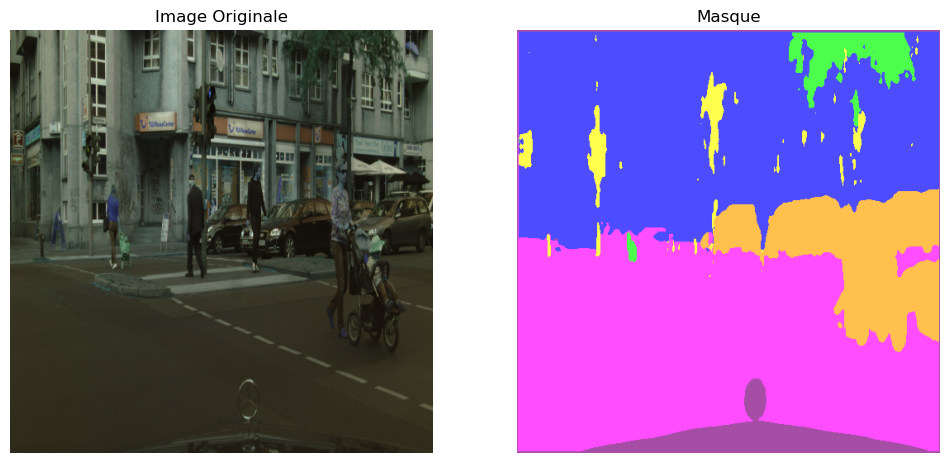

In [472]:
# for i the index of image to check
i = 1
mask_array = prediction[i]

# Charger l'image originale avec OpenCV
original_image_path = os.path.join(test_images_path,os.listdir(test_images_path)[i])
original_image = cv2.imread(original_image_path)

#convert image to mask size
original_image = cv2.resize(original_image, (512, 512))

# Convertir le masque à 8 canaux en masque d'index
mask_channel = (mask_array * 255).astype(np.uint8) #prepare for individual inspection
mask_index = np.argmax(mask_array, axis=-1) 
# Convertir le masque en image OpenCV
mask_image = (mask_index * 255).astype(np.uint8) 

#convert mask to original dimensions
#mask_image = cv2.resize(mask_image, (2048, 1024))

# Créer un masque couleur en utilisant la palette
mask_color = colors[mask_index]

# Afficher les images côte à côte avec Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Afficher l'image originale à droite
axes[0].imshow(original_image)
axes[0].set_title("Image Originale")
axes[0].axis('off')

# Afficher le masque à gauche
#axes[1].imshow(mask_channel[:,:,6], cmap='jet', alpha=0.7) #individual inspection
axes[1].imshow(mask_color, alpha=0.7) #whole mask
axes[1].set_title("Masque")
axes[1].axis('off')

plt.show()

Seems to predict class 5 everywhere. Class 5 is the "sky" class. Our model is overfit to this class ? 

After further training, model seems to react better

In [474]:
model.evaluate(X_val, y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 13s/step - accuracy: 0.8731 - iou: 4.6894 - loss: 20.2470


[19.844194412231445, 0.8805899620056152, 4.745400428771973]

Had excellent results with segmentation_model metrics and losses, but now it's bad

In [477]:
#saving model
model.save('models_in_progress/first_model.keras')  # The file needs to end with the .keras extension
#load model
#model = keras.models.load_model('models_in_progress/first_model.keras')

In [478]:
#don't forget I'll need to import my metrics_and_loss.py when I want to load it somewhere else !
my_model = keras.models.load_model('models_in_progress/first_model.keras')

In [479]:
my_model.evaluate(X_val, y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 12s/step - accuracy: 0.8731 - iou: 4.6894 - loss: 20.2470


[19.844194412231445, 0.8805899620056152, 4.745400428771973]

#### 2nd MODEL : Same backbone / different LR 

In [482]:
# model prep
model2 = sm.Unet(BACKBONE, input_shape=(512, 512, 3), encoder_weights='imagenet', classes=8, activation='softmax')
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=combined_loss, metrics=['accuracy', IoU_score])

In [483]:
t0 = time.time()

model2.fit(
    x=X_train,
    y=y_train,
    batch_size=16,
    epochs=100,
    callbacks = EarlyStop,
    validation_data=(X_val, y_val)
)

t1 = time.time() - t0
print("Took", t1, "seconds")
vgg16_lower_LR_train_time = t1

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 902s 46s/step - accuracy: 0.2277 - iou: 1.5648 - loss: 47.8440 - val_accuracy: 0.2087 - val_iou: 0.5146 - val_loss: 48.7952
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 916s 46s/step - accuracy: 0.4115 - iou: 1.0629 - loss: 45.4124 - val_accuracy: 0.1568 - val_iou: 0.4465 - val_loss: 48.1295
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 870s 46s/step - accuracy: 0.4513 - iou: 1.5942 - loss: 43.8219 - val_accuracy: 0.1934 - val_iou: 0.7500 - val_loss: 47.0138
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 867s 46s/step - accuracy: 0.5978 - iou: 1.8022 - loss: 42.3354 - val_accuracy: 0.4762 - val_iou: 0.8341 - val_loss: 46.1878
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 868s 46s/step - accuracy: 0.6366 - iou: 2.0912 - loss: 40.6207 - val_accuracy: 0.5610 - val_iou: 1.0170 - val_loss: 45.0253
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 922s 46s/step - accuracy: 0.6690 - iou: 2.7583 - loss: 38.4231 - val_accuracy: 0.6448 - val_iou: 1.4129 - val_loss: 43.2114
Epoch 7/100
19/19 ━━━━

In [484]:
#prediction of trained model
prediction2 = model2.predict(X_test, batch_size=16, verbose=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 107s 11s/step


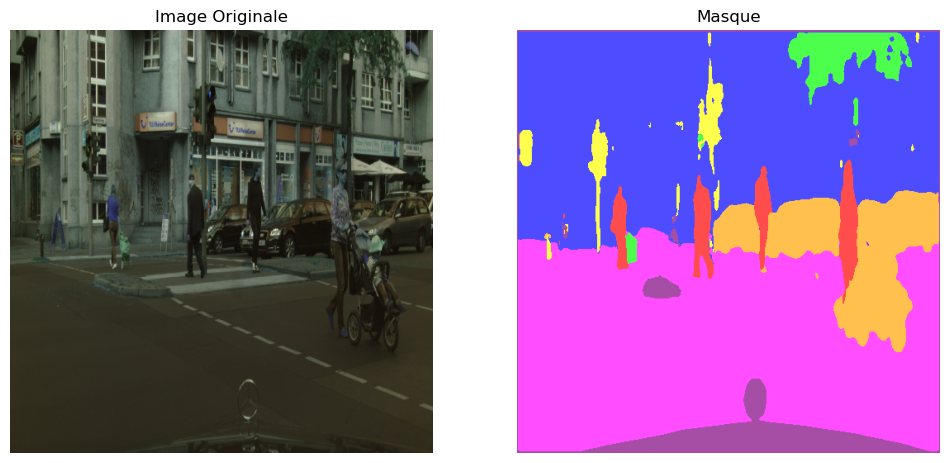

In [485]:
# for i the index of image to check
i = 1
mask_array = prediction2[i]

# Charger l'image originale avec OpenCV
original_image_path = os.path.join(test_images_path,os.listdir(test_images_path)[i])
original_image = cv2.imread(original_image_path)

#convert image to mask size
original_image = cv2.resize(original_image, (512, 512))

# Convertir le masque à 8 canaux en masque d'index
mask_channel = (mask_array * 255).astype(np.uint8) #prepare for individual inspection
mask_index = np.argmax(mask_array, axis=-1) 
# Convertir le masque en image OpenCV
mask_image = (mask_index * 255).astype(np.uint8) 

#convert mask to original dimensions
#mask_image = cv2.resize(mask_image, (2048, 1024))

# Créer un masque couleur en utilisant la palette
mask_color2 = colors[mask_index]

# Afficher les images côte à côte avec Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Afficher l'image originale à droite
axes[0].imshow(original_image)
axes[0].set_title("Image Originale")
axes[0].axis('off')

# Afficher le masque à gauche
#axes[1].imshow(mask_channel[:,:,6], cmap='jet', alpha=0.7) #individual inspection
axes[1].imshow(mask_color2, alpha=0.7) #whole mask
axes[1].set_title("Masque")
axes[1].axis('off')

plt.show()

In [486]:
model2.evaluate(X_val, y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 12s/step - accuracy: 0.8966 - iou: 5.2372 - loss: 17.0329


[16.757265090942383, 0.9031589031219482, 5.280462741851807]

Interesting results ... maybe modify the loss function ? try a mix of categoricalcross entropy and Focal_jaccard ?

In [488]:
model2.save('models_in_progress/second_model.keras')

In [489]:
#free memory
from keras import backend as K
K.clear_session()

In [490]:
#using https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models/

In [491]:
#using https://github.com/zhixuhao/unet

In [492]:
# pushing further in https://encord.com/blog/github-repositories-image-segmentation/

In [493]:
# exploreing power jaccard : https://www.scitepress.org/PublishedPapers/2021/103040/103040.pdf

Piste 1 : récupérer les poids d'entrainement de cityscape directement ? trouver un modèle déjà entrainé \
Piste 1.5 : expérimenter avec un autre Backbone ? Xception ? Vggnet mini ? Resnet50 ? \
Piste 2 : data-augment => gagner du temps / gagner en efficacité \
Montrer qu'on est capable mais rappeler que la data-augment prend du temps \
! Justifier l'augment de data => CHOISIR des données où les classes sont présent et augmenter celles ci \
! Simuler des conditions météo \
SINON augmenter le pourcentage de data choisi 

Piste 3 : Dériver l'entrainement vers GPU pour améliorer le traitement de l'image \
! Mettre dans la note technique la différence de traitement par CPU et par GPU !


#### 3rd MODEL : ResNet50 BACKBONE

In [497]:
#RESNET50
BACKBONE = 'resnet50'
preprocess_input = get_preprocessing(BACKBONE)

#model with CatCross+Jaccard Loss
model_resnet = sm.Unet(BACKBONE, input_shape=(512, 512, 3), encoder_weights='imagenet', classes=8, activation='softmax')
model_resnet.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=combined_loss, metrics=['accuracy', IoU_score])

In [498]:
#model fit
t0 = time.time()

model_resnet.fit(
    x=X_train,
    y=y_train,
    batch_size=16,
    epochs=100,
    callbacks = EarlyStop,
    validation_data=(X_val, y_val)
)

t1 = time.time() - t0
print("Took", t1, "seconds")
resnet_train_time = t1

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 533s 24s/step - accuracy: 0.3942 - iou: 2.4156 - loss: 44.3885 - val_accuracy: 0.1135 - val_iou: 0.1532 - val_loss: 176.8584
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 475s 23s/step - accuracy: 0.8396 - iou: 3.8475 - loss: 32.6260 - val_accuracy: 0.1200 - val_iou: 0.2009 - val_loss: 51.1602
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 435s 23s/step - accuracy: 0.8628 - iou: 4.1905 - loss: 25.4163 - val_accuracy: 0.0694 - val_iou: 0.1754 - val_loss: 48.6218
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 435s 23s/step - accuracy: 0.8790 - iou: 4.2920 - loss: 23.2573 - val_accuracy: 0.1966 - val_iou: 0.3030 - val_loss: 48.3230
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 434s 23s/step - accuracy: 0.8690 - iou: 4.3100 - loss: 22.6268 - val_accuracy: 0.1676 - val_iou: 0.2472 - val_loss: 50.2639
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 435s 23s/step - accuracy: 0.8816 - iou: 4.4566 - loss: 21.4749 - val_accuracy: 0.2009 - val_iou: 0.2816 - val_loss: 49.6482
Epoch 7/100
19/19 ━━━

In [499]:
prediction_resnet = model_resnet.predict(X_test, batch_size=16, verbose=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 67s 6s/step


In [500]:
model_resnet.save('models_in_progress/resnet_model.keras')

In [501]:
#free memory
K.clear_session()

#### 4th MODEL : inceptionv3 BACKBONE

In [502]:
#Inception
BACKBONE = 'inceptionv3'
preprocess_input = get_preprocessing(BACKBONE)

#EarlyStop function
EarlyStop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    start_from_epoch=0
)

model_inception = sm.Unet(BACKBONE, input_shape=(512, 512, 3), encoder_weights='imagenet', classes=8, activation='softmax')
model_inception.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=combined_loss, metrics=['accuracy', IoU_score])

In [503]:
#model fit
t0 = time.time()

model_inception.fit(
    x=X_train,
    y=y_train,
    batch_size=16,
    epochs=100,
    callbacks = EarlyStop,
    validation_data=(X_val, y_val)
)

t1 = time.time() - t0
print("Took", t1, "seconds")
inceptionv3_train_time = t1

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 488s 20s/step - accuracy: 0.4648 - iou: 2.3498 - loss: 44.6518 - val_accuracy: 0.1304 - val_iou: 0.2676 - val_loss: 55.0130
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 366s 19s/step - accuracy: 0.8460 - iou: 3.9072 - loss: 30.9055 - val_accuracy: 0.1110 - val_iou: 0.2193 - val_loss: 51.9972
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 367s 19s/step - accuracy: 0.8687 - iou: 4.2119 - loss: 25.0636 - val_accuracy: 0.4250 - val_iou: 1.5298 - val_loss: 43.2757
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 366s 19s/step - accuracy: 0.8816 - iou: 4.4455 - loss: 22.3030 - val_accuracy: 0.3705 - val_iou: 1.2335 - val_loss: 44.3608
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 383s 19s/step - accuracy: 0.8812 - iou: 4.4579 - loss: 21.6740 - val_accuracy: 0.2922 - val_iou: 0.7201 - val_loss: 47.0034
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 367s 19s/step - accuracy: 0.8831 - iou: 4.5107 - loss: 21.1306 - val_accuracy: 0.2876 - val_iou: 1.1686 - val_loss: 44.1032
Epoch 7/100
19/19 ━━━━

In [504]:
prediction_inception = model_inception.predict(X_test, batch_size=16, verbose=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step


In [505]:
model_inception.save('models_in_progress/inception_model.keras')

In [506]:
#free memory
K.clear_session()

In [507]:
def prepare_mask_array(mask_array):
    # Convertir le masque à 8 canaux en masque d'index
    mask_channel = (mask_array * 255).astype(np.uint8) #prepare for individual inspection
    mask_index = np.argmax(mask_array, axis=-1) 
    # Convertir le masque en image OpenCV
    #mask_image = (mask_index * 255).astype(np.uint8)
    mask_image = colors[mask_index]
    
    return mask_channel, mask_image

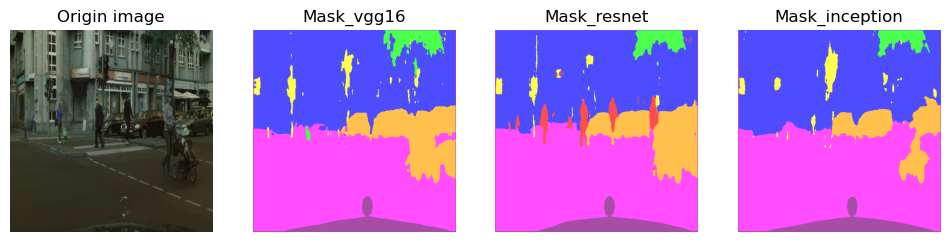

In [508]:
# for i the index of image to check
i = 1
mask_array_vgg16 = prediction[i]
mask_array_vgg16_lowerLR = prediction2[i]
mask_array_resnet = prediction_resnet[i]
mask_array_inception = prediction_inception[i]

# load image with OpenCV
original_image_path = os.path.join(test_images_path,os.listdir(test_images_path)[i])
original_image = cv2.imread(original_image_path)

# convert image to mask size
original_image = cv2.resize(original_image, (512, 512))

# prepare each masks and channels
vgg16_channel, vgg16_image = prepare_mask_array(mask_array_vgg16)
vgg16_channel_lowerLR, vgg16_image_lowerLR = prepare_mask_array(mask_array_vgg16_lowerLR)
resnet_channel, resnet_image = prepare_mask_array(mask_array_resnet)
inception_channel, inception_image = prepare_mask_array(mask_array_inception)


#create mask with color map
ind_vgg16 = (vgg16_image/255).astype(np.uint8)
mask_color_vgg16 = colors[ind_vgg16]

#display image
fig, axes = plt.subplots(1, 5, figsize=(12, 6))

#original image on the right
axes[0].imshow(original_image)
axes[0].set_title("Origin image")
axes[0].axis('off')

#mask on the left
#axes[1].imshow(vgg16_channel[:,:,6], cmap='jet', alpha=0.7) #individual inspection
axes[1].imshow(vgg16_image, alpha=0.7) #whole mask #je triche en utilisant le mask fait plus haut mais pas grave
axes[1].set_title("Mask_vgg16")
axes[1].axis('off')

axes[2].imshow(vgg16_image_lowerLR, cmap='jet', alpha=0.7) #whole mask
axes[2].set_title("Mask_resnet")
axes[2].axis('off')

axes[3].imshow(resnet_image, cmap='jet', alpha=0.7) #whole mask
axes[3].set_title("Mask_resnet")
axes[3].axis('off')

axes[4].imshow(inception_image, cmap='jet', alpha=0.7) #whole mask
axes[4].set_title("Mask_inception")
axes[4].axis('off')

plt.show()

In [509]:
i = np.argmax(mask_array_vgg16, axis=-1) 
np.unique(i)
#NO HUMANS ??? OR NO SKY ???

array([0, 1, 2, 3, 4, 7], dtype=int64)

To further inquiries, we should now proceed to data-augmentation, see how it can improve results, and how it impacts training and overall process

### Data-Augmentation

In order to data-augment our set, we will use Albumentation library

In [513]:
import albumentations as A

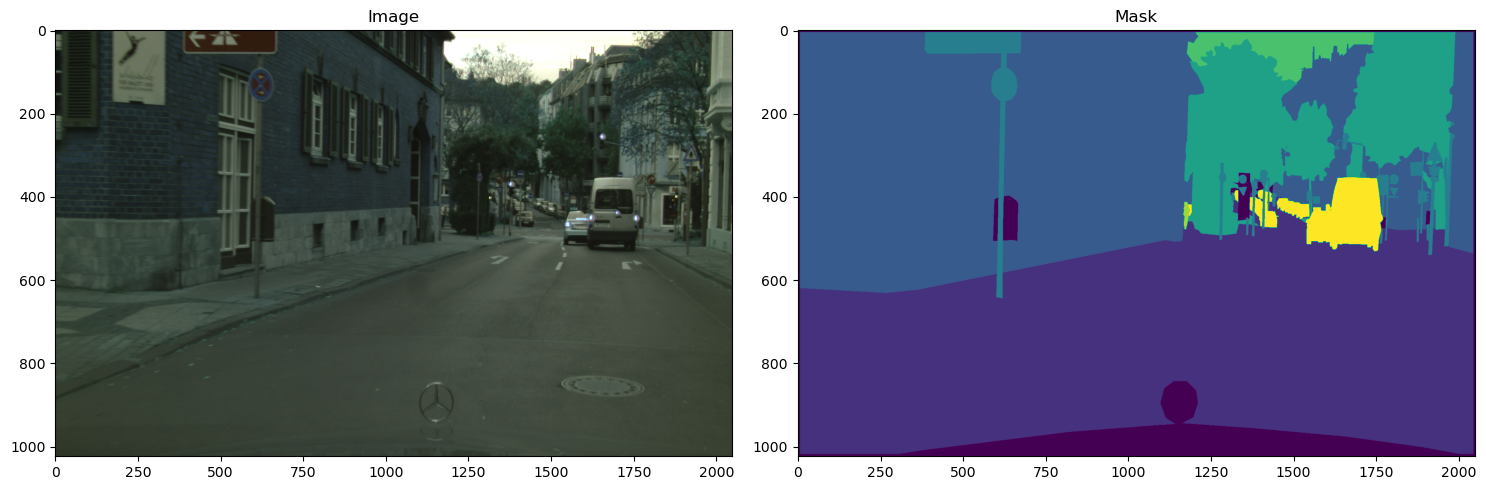

In [514]:
train_image_dir = "data/train/images"
train_mask_dir = "data/train/gen_masks"
val_image_dir = 'data/val/images'
val_mask_dir = 'data/val/gen_masks'

#visualize image and mask before transformation
img_path = os.path.join(train_image_dir, os.listdir(train_image_dir)[1])
mask_path = os.path.join(train_mask_dir, os.listdir(train_mask_dir)[1])
img = cv2.imread(img_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1, 2, figsize=(15, 5)) #set 2 columns to examine differences between originals and modifications

ax[0].imshow(img, aspect='auto')
ax[0].set_title("Image")

ax[1].imshow(mask, aspect='auto')
ax[1].set_title("Mask")

plt.tight_layout()
plt.show()

In [515]:
#prepare transformation from documentation
pipeline = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5), # 50% chance to flip
    A.RandomBrightnessContrast(p=0.8), # 80% chance to adjust brightness/contrast
    A.GaussianBlur(p=0.3), # 30% chance to blur
])

transformed_data = pipeline(image=img, mask=mask)

#transformed_data['image']

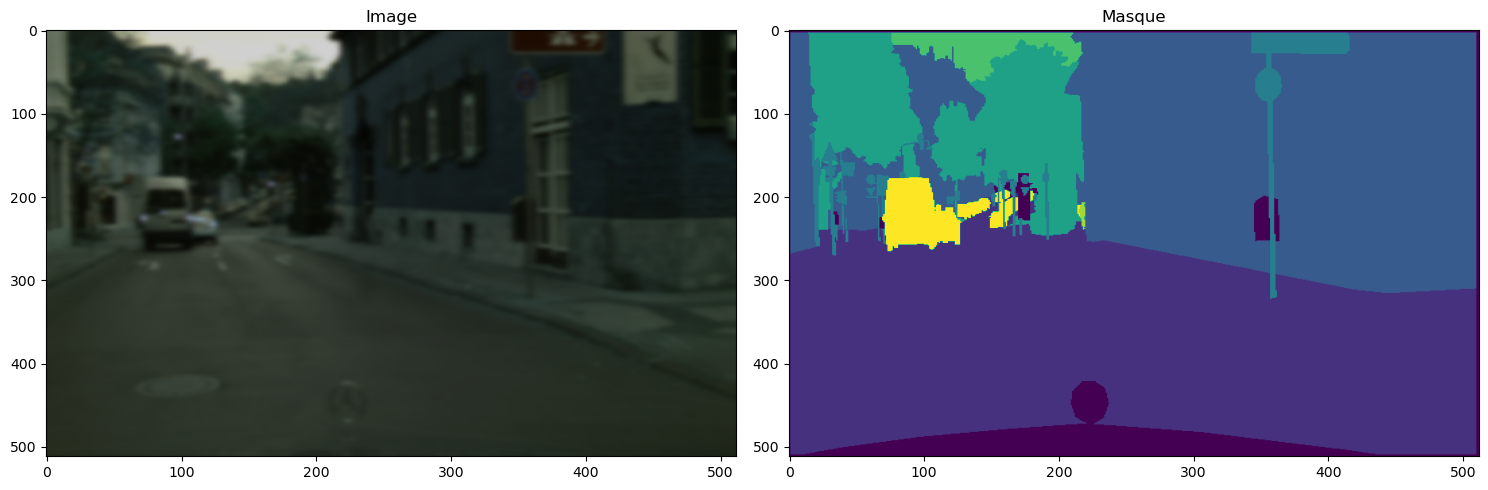

In [516]:
new_img=transformed_data['image']
new_mask=transformed_data['mask']

#visualize images and masks
fig, ax = plt.subplots(1, 2, figsize=(15, 5)) #set 2 columns to examine differences between originals and modifications
ax[0].imshow(new_img, aspect='auto')
ax[0].set_title("Image")

ax[1].imshow(new_mask, aspect='auto')
ax[1].set_title("Masque")

"""ax[0].imshow(img, aspect='auto') 
ax[0].set_title("Image")

ax[1].imshow(mask, aspect='auto')
ax[1].set_title("Masque")"""

plt.tight_layout()
plt.show()

Need to expriment on : 
- A.togray or A.ChannelDropout : in order to avoid model dependance to colors
- A.affine : for multiple geometric transformation at once

Take it out to a dedicated notebook ! 

### Treating and comparing results

In [ ]:
'''to each dict I should add the training time

vgg16_train_time
vgg16_lower_LR_train_time
resnet_train_time
inceptionv3_train_time
'''




In [63]:
#loading all models
model_VGG16 = keras.models.load_model('models_in_progress/first_model.keras')
model_VGG16_LR = keras.models.load_model('models_in_progress/second_model.keras')
model_ResNet50 = keras.models.load_model('models_in_progress/resnet_model.keras')
model_InceptionV3 = keras.models.load_model('models_in_progress/inception_model.keras')

#evaluate all models
result_VGG16 = model_VGG16.evaluate(X_val, y_val, return_dict=True)
result_VGG16_lower_LR = model_VGG16_LR.evaluate(X_val, y_val, return_dict=True)
result_ResNet50 = model_ResNet50.evaluate(X_val, y_val, return_dict=True)
result_InceptionV3 = model_InceptionV3.evaluate(X_val, y_val, return_dict=True)

2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 13s/step - accuracy: 0.8731 - iou: 4.6894 - loss: 20.2470
2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 12s/step - accuracy: 0.8966 - iou: 5.2372 - loss: 17.0329
2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - accuracy: 0.8803 - iou: 4.9320 - loss: 18.8406
2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 0.8758 - iou: 4.7815 - loss: 19.6187


In [67]:
#adding train time to each dict
result_VGG16["train_time"] = vgg16_train_time
result_VGG16_lower_LR["train_time"] = vgg16_lower_LR_train_time
result_VGG16["train_time"] = resnet_train_time
result_VGG16["train_time"] = inceptionv3_train_time

result_dict = {
    "result_VGG16": result_VGG16,
    "result_VGG16_lower_LR": result_VGG16_lower_LR,
    "result_ResNet50": result_ResNet50,
    "result_InceptionV3": result_InceptionV3
}
result_dict

{'result_VGG16': {'accuracy': 0.8805899620056152,
  'iou': 4.745400428771973,
  'loss': 19.844194412231445},
 'result_VGG16_LR': {'accuracy': 0.9031589031219482,
  'iou': 5.280462741851807,
  'loss': 16.757265090942383},
 'result_ResNet50': {'accuracy': 0.8879595994949341,
  'iou': 4.988475322723389,
  'loss': 18.44904899597168},
 'result_InceptionV3': {'accuracy': 0.8824706077575684,
  'iou': 4.820293426513672,
  'loss': 19.331396102905273}}

In [71]:
result_df = pd.DataFrame.from_dict(result_dict, orient='index')
print(result_df)

                    accuracy       iou       loss
result_VGG16        0.880590  4.745400  19.844194
result_VGG16_LR     0.903159  5.280463  16.757265
result_ResNet50     0.887960  4.988475  18.449049
result_InceptionV3  0.882471  4.820293  19.331396


Here we can see that all encoders have similar capacities, but a reduced LR seems to improve results